Energy Disaggregation using Neural Networks
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


In [2]:
from keras.layers.normalization import BatchNormalization

The following functions are used to extract the time and day information from a timestamp value.

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [4]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [5]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [6]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing for ECO - Summer
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [3]:
from os import walk
path = "C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/05_sm_csv/05"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [4]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

215

In [5]:
df2 = pd.read_csv("C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/05_occupancy_csv/05_summer.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

43

In [6]:
import datetime
summer = df2.index.tolist()
# for i in range(len(summer)):
#     item = pd.to_datetime(summer[i])
#     item = item.strftime('%Y%m%d')
#     summer[i] = item
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
len(df_summer)
#df_summer["20120730"]

43

In [10]:
n = 900  #chunk row size
summer_features = pd.DataFrame()
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_summer:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
#     data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
#                                             std1,std2,std3,std123,range1,range2,range3,range123,ptime)), 
#                             columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
#                                        'mean123','std1','std2','std3','std123',
#                                        'range1','range2','range3','range123','ptime'])
    
    summer_features = summer_features.append(data)
summer_features.loc[summer_features.ptime < 25, 'ptime'] = 0
summer_features.loc[summer_features.ptime > 89, 'ptime'] = 0
summer_features = summer_features.loc[(summer_features['ptime'] >0)]
summer_features['ptime'] = summer_features['ptime'] - 24

#         print(summer_features)
#        break

In [11]:
summer_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,63.673,33.151,67.639,165.579,1024.030,34.052,1783.190,1884.130,83.543792,33.616968,...,0.937854,0.0,0.0,0.0,0.0,960.357,0.901,1715.551,1718.551,1.0
25,66.370,33.275,68.368,168.977,147.966,34.152,1011.140,1112.080,69.184174,33.698298,...,0.540531,0.0,0.0,0.0,0.0,81.596,0.877,942.772,943.103,2.0
26,65.659,32.980,67.888,167.775,1013.510,38.436,1453.100,1552.780,85.253546,33.411254,...,0.894901,0.0,0.0,0.0,0.0,947.851,5.456,1385.212,1385.005,3.0
27,52.764,33.003,174.426,260.852,146.658,33.828,234.485,370.553,61.583636,33.384162,...,0.981070,0.0,0.0,0.0,0.0,93.894,0.825,60.059,109.701,4.0
28,49.357,32.884,68.388,255.598,1678.030,1451.990,972.102,2362.950,566.352368,218.132486,...,0.993812,0.0,0.0,0.0,0.0,1628.673,1419.106,903.714,2107.352,5.0
29,752.548,33.222,68.155,854.949,842.505,172.494,73.355,998.754,761.552434,52.513484,...,0.993740,0.0,0.0,0.0,0.0,89.957,139.272,5.200,143.805,6.0
30,755.190,33.222,68.630,858.043,1713.150,38.455,502.382,1899.130,778.271326,33.750074,...,0.954133,0.0,0.0,0.0,0.0,957.960,5.233,433.752,1041.087,7.0
31,53.799,33.151,68.592,513.708,761.925,34.138,587.565,1033.330,460.309226,33.650677,...,0.971724,0.0,0.0,0.0,0.0,708.126,0.987,518.973,519.622,8.0
32,53.828,33.404,394.668,483.425,1020.670,360.830,1303.210,1555.760,71.492933,49.914591,...,0.956443,0.0,0.0,0.0,0.0,966.842,327.426,908.542,1072.335,9.0
33,53.923,33.475,395.886,484.082,135.938,34.290,1470.740,1559.350,57.645348,33.880070,...,0.555425,0.0,0.0,0.0,0.0,82.015,0.815,1074.854,1075.268,10.0


In [12]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_summer = []
    list_oc_summer = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_summer:
        occ_summer.append(np.bincount(chunk).argmax())
    occ_summer = occ_summer[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_summer)
#     print(len(cuml_list))
occ_summer_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
# print(occ_summer_data)    
#     print(len(list_oc_summer))
#     if row[0] > '06:00:00':
#         print(row[1])
    

In [13]:
occ_summer_data

,occupancy
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,0
9,0


In [14]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

In [15]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

Standardizing data
================

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(summer_features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
summer_std = scaler.transform(summer_features)

In [18]:
summer_std[np.isnan(summer_std)] = 0

PCA
====

In [19]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [20]:
pca.fit(summer_std)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
pca.n_components_

19

In [22]:
summer_pca = pca.transform(summer_std)

In [23]:
summer_pca.shape

(2795, 19)

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_pca, occ_summer_data, test_size=0.15,shuffle=True)

In [111]:
X_train.shape

(2375, 19)

Model Specification
-------------------------------
The following function is used to create the model.

In [59]:
def init_model():
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(19,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True,
#                                   stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [36]:
def create_seq(X):
    res = []
    rem = X.shape[0] % 4
    for i in range(0,X.shape[0],4):
#         print(i)
        if  (i+4) > X.shape[0]:
            balc = X.shape[0] - i
            res.append(np.concatenate((X[i:i+balc,:],np.zeros((i+4 - X.shape[0],X.shape[1])))))
        else:
            res.append(X[i:i+4,:])
    res = np.array(res)
#     print(len(res))
    return res
   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 19, 256)           1280      
_________________________________________________________________
batch_normalization_7 (Batch (None, 19, 256)           1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 19, 128)           131200    
_________________________________________________________________
batch_normalization_8 (Batch (None, 19, 128)           512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 19, 64)            32832     
__________

2375/2375 [==============================] - 2s 835us/step - loss: 0.2557 - acc: 0.8884 - val_loss: 0.2789 - val_acc: 0.9119
Epoch 39/200
2375/2375 [==============================] - 2s 819us/step - loss: 0.2538 - acc: 0.8867 - val_loss: 0.2806 - val_acc: 0.9095
Epoch 40/200
2375/2375 [==============================] - 2s 843us/step - loss: 0.2555 - acc: 0.8838 - val_loss: 0.2775 - val_acc: 0.9119
Epoch 41/200
2375/2375 [==============================] - 2s 817us/step - loss: 0.2461 - acc: 0.8909 - val_loss: 0.2845 - val_acc: 0.9048
Epoch 42/200
2375/2375 [==============================] - 2s 832us/step - loss: 0.2542 - acc: 0.8905 - val_loss: 0.2876 - val_acc: 0.9119
Epoch 43/200
2375/2375 [==============================] - 2s 835us/step - loss: 0.2624 - acc: 0.8884 - val_loss: 0.2687 - val_acc: 0.9095
Epoch 44/200
2375/2375 [==============================] - 2s 813us/step - loss: 0.2580 - acc: 0.8872 - val_loss: 0.2628 - val_acc: 0.9119
Epoch 45/200
2375/2375 [=======================

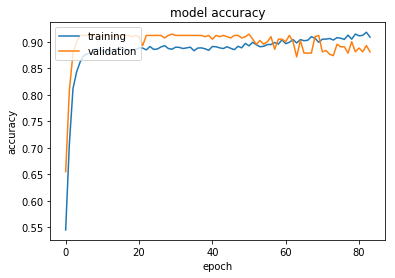

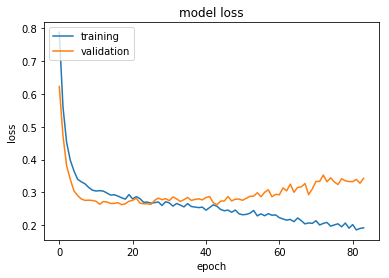

In [37]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
model = init_model()
model.summary()
# X_train = create_seq(X_train)
# y_train = create_seq(y_train.values)
# X_test = create_seq(X_test)
# y_test = create_seq(y_test.values)
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
history = model.fit(X_train, y_train, epochs=200, batch_size=32,validation_data=(X_test,y_test),callbacks=[es])
score = model.evaluate(X_test, y_test, batch_size=32)
print(score)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

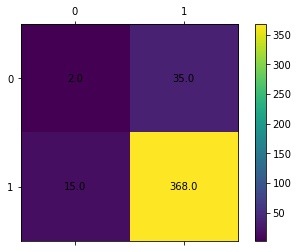

In [38]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


K-fold Cross Validation
----------------------

In [54]:
from sklearn.model_selection import StratifiedKFold

In [55]:
Xs=summer_pca
ys=occ_summer_data.values

400/400 [==============================] - 0s 215us/step


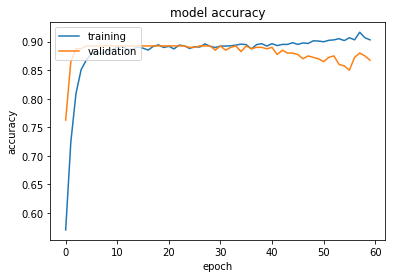

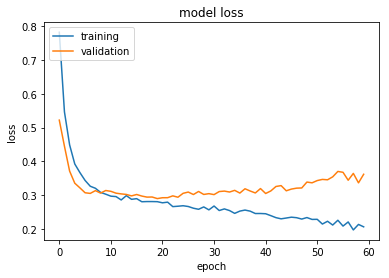

acc: 86.75%
loss: 0.36%
400/400 [==============================] - 0s 256us/step


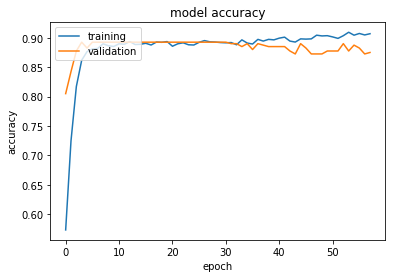

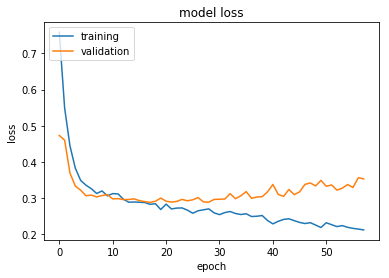

acc: 87.50%
loss: 0.35%
400/400 [==============================] - 0s 283us/step


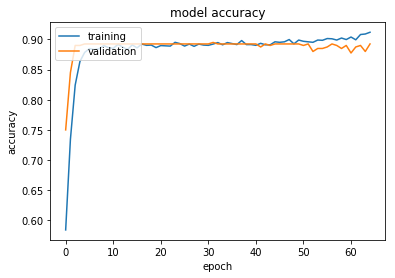

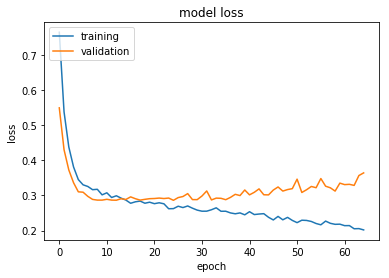

acc: 89.25%
loss: 0.36%
400/400 [==============================] - 0s 257us/step


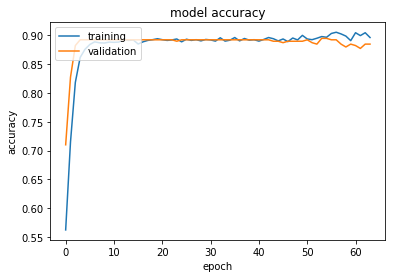

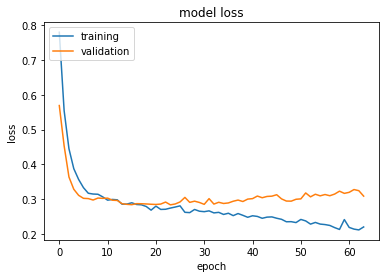

acc: 88.50%
loss: 0.31%
399/399 [==============================] - 0s 303us/step


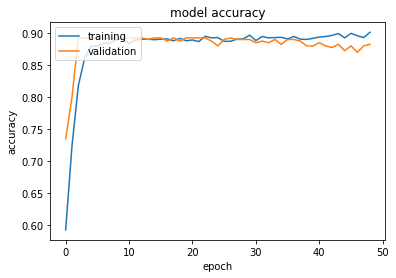

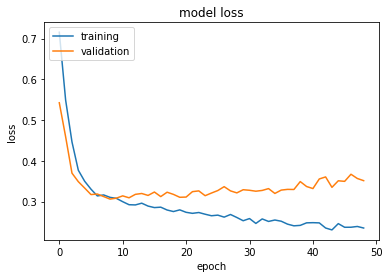

acc: 88.22%
loss: 0.35%
398/398 [==============================] - 0s 293us/step


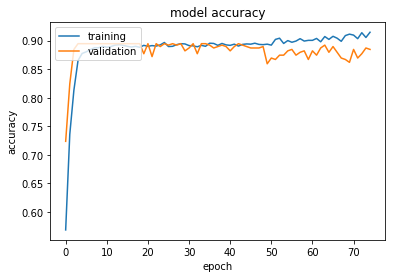

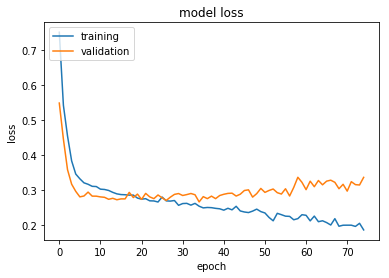

acc: 88.44%
loss: 0.34%
398/398 [==============================] - 0s 334us/step


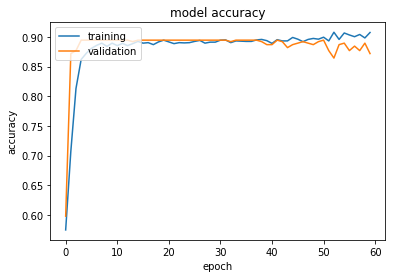

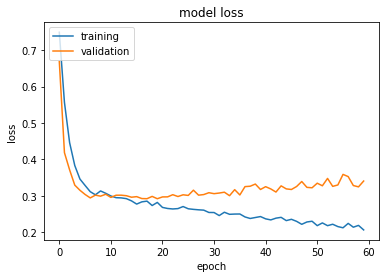

acc: 87.19%
loss: 0.34%
87.98% (+/- 0.80%)


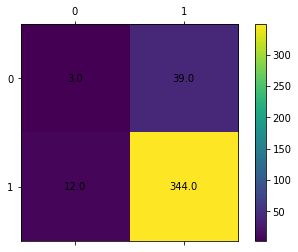

In [61]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    model = init_model()
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

PCA + SVM
=============

In [112]:
from sklearn.svm import SVC
svclassifier = SVC()
svclassifier.fit(X_train, y_train)

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [113]:
y_pred = svclassifier.predict(X_test)

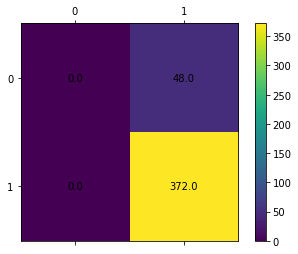

In [114]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


In [115]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8857142857142857


K-fold
------------

In [116]:
from sklearn.model_selection import StratifiedKFold

In [117]:
Xs=summer_pca
ys=occ_summer_data.values

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.25%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.25%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.25%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.25%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.22%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.45%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.45%
89.30% (+/- 0.09%)


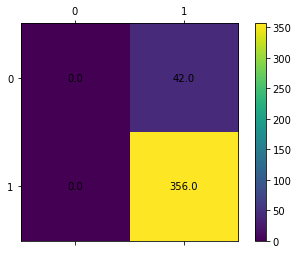

In [118]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train]
    X_test = Xs[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, ys[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    acc = accuracy_score(ys[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Naked NN
================

In [62]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [64]:
# X = np.array(summer_features)
# print('X dim: ',X.shape)
# y = np.array(occ_summer_data)
# print('y dim: ',y.shape)

# X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_std, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_test dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_test dim: ', y_test.shape)

X_train dim:  (2375, 33, 1)
X_test dim:  (420, 33, 1)
y_train dim:  (2375, 1)
y_test dim:  (420, 1)


In [65]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_73 (Batc (None, 33, 256)           1024      
_________________________________________________________________
dropout_73 (Dropout)         (None, 33, 256)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_74 (Batc (None, 33, 128)           512       
_________________________________________________________________
dropout_74 (Dropout)         (None, 33, 128)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 33, 64)            32832     
__________

Train on 2375 samples, validate on 420 samples
Epoch 1/150
 - 9s - loss: 0.7273 - acc: 0.5882 - val_loss: 0.5850 - val_acc: 0.6619
Epoch 2/150
 - 4s - loss: 0.5405 - acc: 0.7322 - val_loss: 0.4496 - val_acc: 0.8143
Epoch 3/150
 - 4s - loss: 0.4311 - acc: 0.8312 - val_loss: 0.3784 - val_acc: 0.8905
Epoch 4/150
 - 4s - loss: 0.3886 - acc: 0.8531 - val_loss: 0.3607 - val_acc: 0.8929
Epoch 5/150
 - 4s - loss: 0.3435 - acc: 0.8804 - val_loss: 0.3322 - val_acc: 0.8952
Epoch 6/150
 - 4s - loss: 0.3242 - acc: 0.8842 - val_loss: 0.3195 - val_acc: 0.8952
Epoch 7/150
 - 4s - loss: 0.3174 - acc: 0.8808 - val_loss: 0.3177 - val_acc: 0.8952
Epoch 8/150
 - 4s - loss: 0.3101 - acc: 0.8846 - val_loss: 0.3196 - val_acc: 0.8976
Epoch 9/150
 - 4s - loss: 0.3030 - acc: 0.8842 - val_loss: 0.3133 - val_acc: 0.8952
Epoch 10/150
 - 4s - loss: 0.3031 - acc: 0.8888 - val_loss: 0.3090 - val_acc: 0.8952
Epoch 11/150
 - 4s - loss: 0.3019 - acc: 0.8897 - val_loss: 0.3148 - val_acc: 0.8952
Epoch 12/150
 - 4s - loss: 

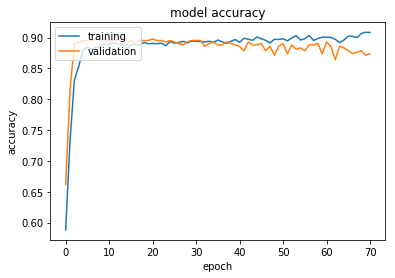

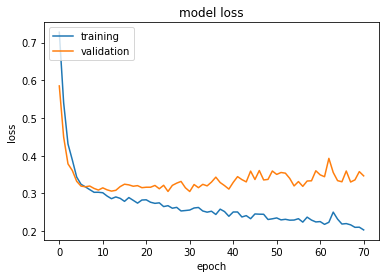

In [66]:
# history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[es],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

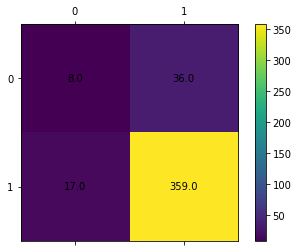

In [67]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test,y_test)

K-fold Validation 
=================

In [68]:
from sklearn.model_selection import StratifiedKFold

In [69]:
Xs=summer_std
ys=occ_summer_data.values

400/400 [==============================] - 0s 575us/step


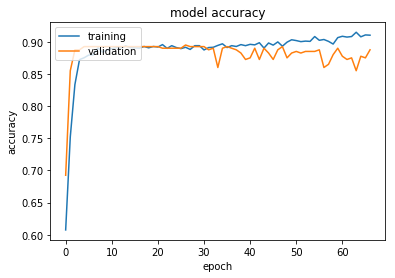

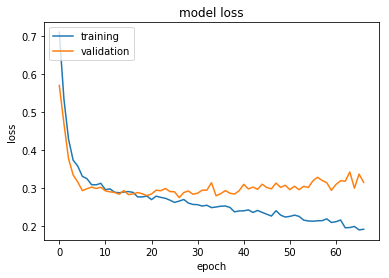

acc: 88.75%
loss: 0.32%
400/400 [==============================] - 0s 518us/step


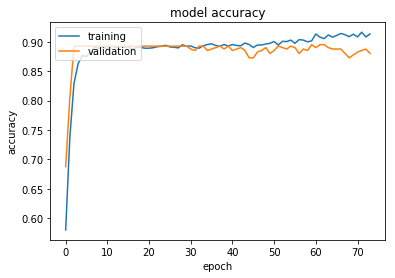

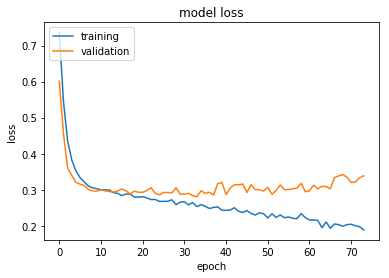

acc: 88.00%
loss: 0.34%
400/400 [==============================] - 0s 578us/step


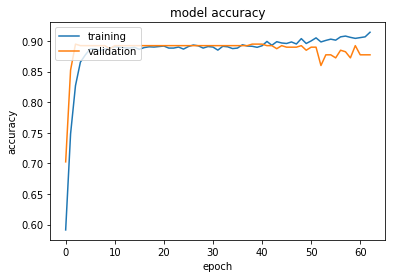

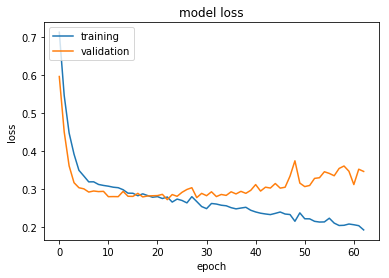

acc: 87.75%
loss: 0.35%
400/400 [==============================] - 0s 610us/step


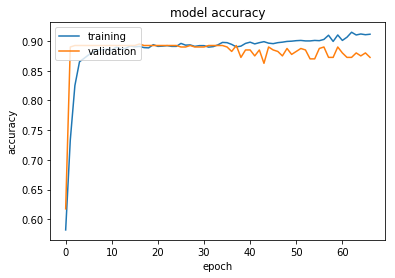

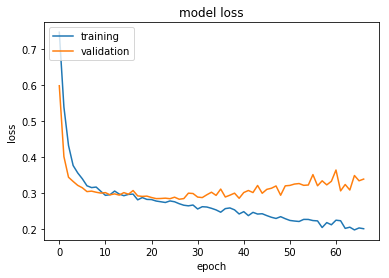

acc: 87.25%
loss: 0.34%
399/399 [==============================] - 0s 639us/step


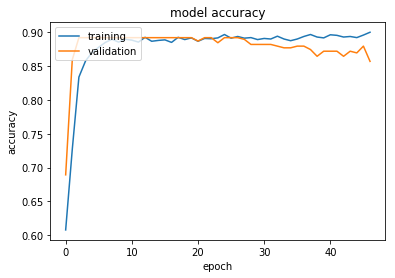

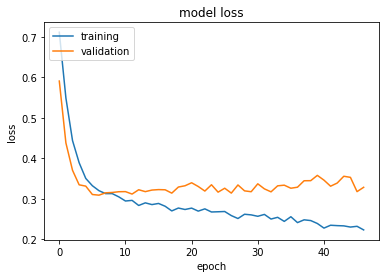

acc: 85.71%
loss: 0.33%
398/398 [==============================] - 0s 700us/step


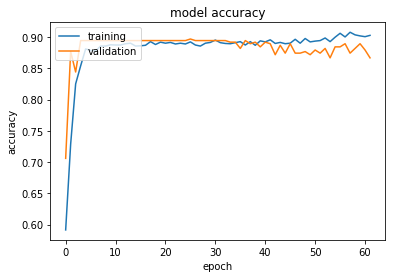

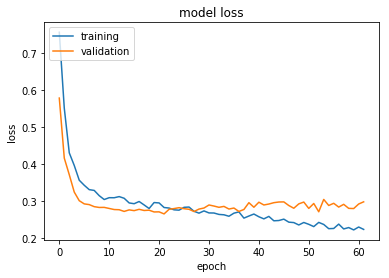

acc: 86.68%
loss: 0.30%
398/398 [==============================] - 0s 728us/step


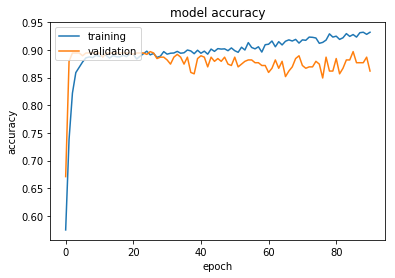

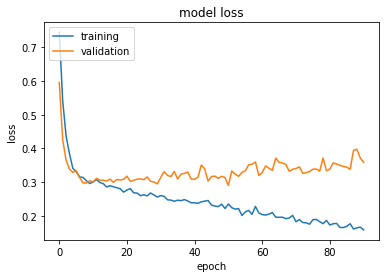

acc: 86.18%
loss: 0.36%
87.19% (+/- 0.99%)


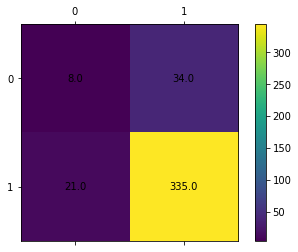

In [70]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    features = X_train.shape[1]
    model = init_model(features)
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Shapely Values
===============

In [71]:
# X = np.array(summer_features)
# print('X dim: ',X.shape)
# y = np.array(occ_summer_data)
# print('y dim: ',y.shape)

# X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_std, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_test dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_test dim: ', y_test.shape)

X_train dim:  (2375, 33, 1)
X_test dim:  (420, 33, 1)
y_train dim:  (2375, 1)
y_test dim:  (420, 1)


In [72]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(2375, 33, 1)

In [73]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [74]:
features = X_train.shape[1]
model = init_model(features)
model.summary()
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_121 (Bat (None, 33, 256)           1024      
_________________________________________________________________
dropout_121 (Dropout)        (None, 33, 256)           0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_122 (Bat (None, 33, 128)           512       
_________________________________________________________________
dropout_122 (Dropout)        (None, 33, 128)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 33, 64)            32832     
__________

In [75]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(2375, 33)

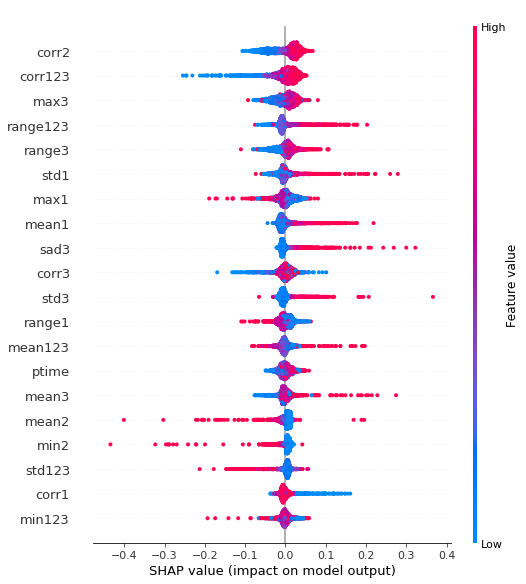

In [76]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

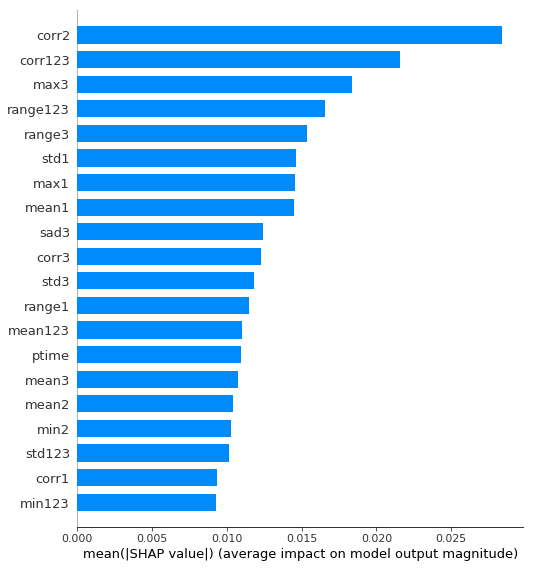

In [77]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

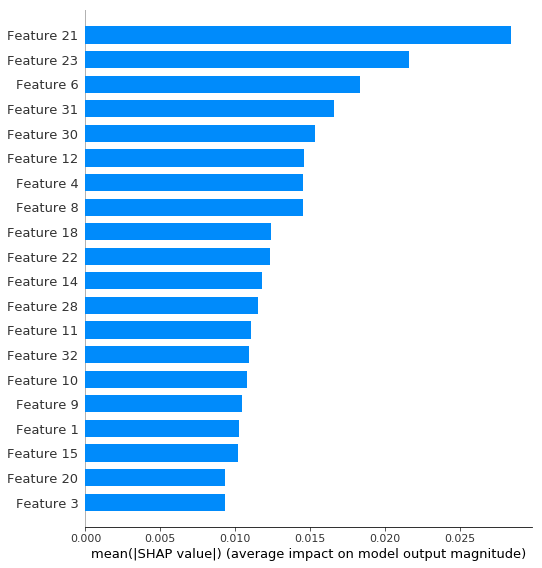

In [78]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely
======================

In [98]:
new_summer_features= summer_std[:,1:2]
new_summer_features = np.concatenate((new_summer_features, summer_std[:,3:5], summer_std[:,6:7],summer_std[:,8:13],
                                     summer_std[:,14:16],summer_std[:,18:19],summer_std[:,20:24],summer_std[:,28:29],
                                      summer_std[:,30:33]),axis=1)
new_summer_features.shape


(2795, 20)

In [103]:
# X_train1 =new_summer_features[0:2200,:]
# X_test1 = new_summer_features[2200:2535,:]

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_summer_features, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)
X_test1.shape

(420, 20, 1)

In [104]:
model = init_model(X_train1.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_139 (Bat (None, 20, 256)           1024      
_________________________________________________________________
dropout_139 (Dropout)        (None, 20, 256)           0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_140 (Bat (None, 20, 128)           512       
_________________________________________________________________
dropout_140 (Dropout)        (None, 20, 128)           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 20, 64)            32832     
__________

Train on 2375 samples, validate on 420 samples
Epoch 1/200
 - 17s - loss: 0.7356 - acc: 0.6160 - val_loss: 0.6091 - val_acc: 0.7143
Epoch 2/200
 - 5s - loss: 0.5549 - acc: 0.7419 - val_loss: 0.4875 - val_acc: 0.8143
Epoch 3/200
 - 5s - loss: 0.4419 - acc: 0.8173 - val_loss: 0.3835 - val_acc: 0.8690
Epoch 4/200
 - 5s - loss: 0.3843 - acc: 0.8568 - val_loss: 0.3447 - val_acc: 0.8786
Epoch 5/200
 - 5s - loss: 0.3569 - acc: 0.8733 - val_loss: 0.3186 - val_acc: 0.8857
Epoch 6/200
 - 5s - loss: 0.3431 - acc: 0.8834 - val_loss: 0.3240 - val_acc: 0.8857
Epoch 7/200
 - 5s - loss: 0.3318 - acc: 0.8808 - val_loss: 0.3124 - val_acc: 0.8857
Epoch 8/200
 - 5s - loss: 0.3235 - acc: 0.8813 - val_loss: 0.3079 - val_acc: 0.8857
Epoch 9/200
 - 5s - loss: 0.3179 - acc: 0.8893 - val_loss: 0.3105 - val_acc: 0.8857
Epoch 10/200
 - 5s - loss: 0.3244 - acc: 0.8808 - val_loss: 0.3175 - val_acc: 0.8857
Epoch 11/200
 - 5s - loss: 0.3166 - acc: 0.8846 - val_loss: 0.3117 - val_acc: 0.8857
Epoch 12/200
 - 5s - loss:

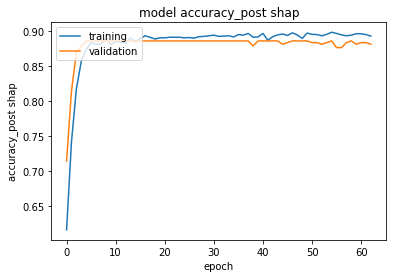

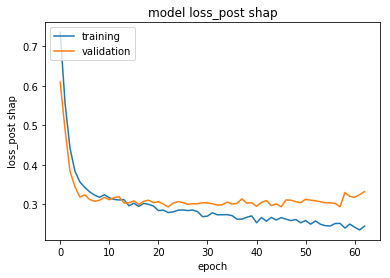

In [105]:
# history1 = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss1 = model.fit(X_train1, y_train1, epochs=200, batch_size=32,
                callbacks=[es],
                validation_data=(X_test1,y_test1), verbose=2)
score1 = model.evaluate(X_test1, y_test1, batch_size=64)
print(score1)
plt.plot(hiss1.history['acc'])
plt.plot(hiss1.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss1.history['loss'])
plt.plot(hiss1.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test1)

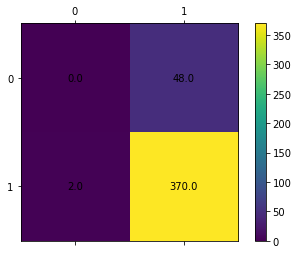

In [106]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test1,y_test1)

K-fold Validation 
=================

In [107]:
from sklearn.model_selection import StratifiedKFold

In [108]:
Xs=new_summer_features
ys=occ_summer_data.values

400/400 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 970us/step


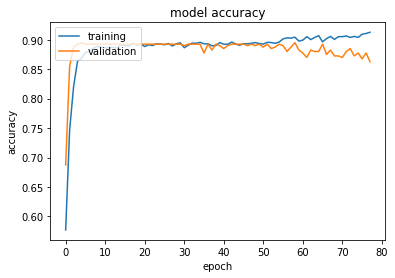

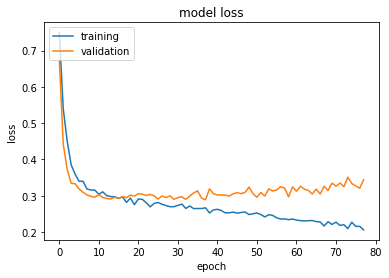

acc: 86.25%
loss: 0.34%
400/400 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 1ms/step


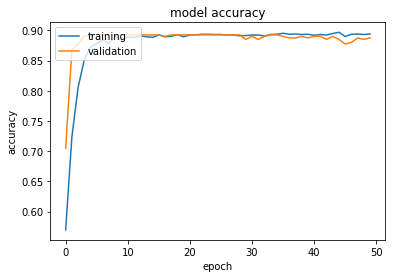

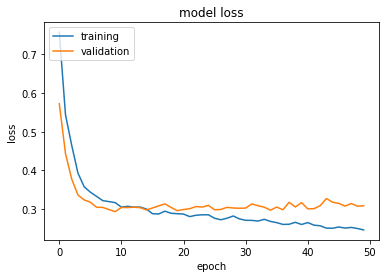

acc: 88.75%
loss: 0.31%
400/400 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 1ms/step


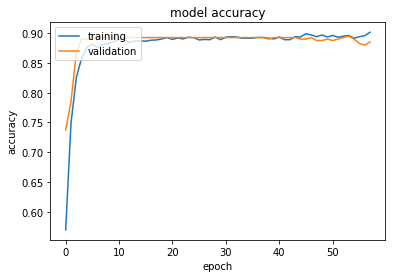

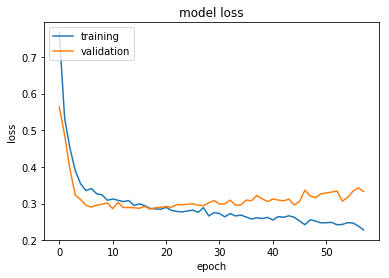

acc: 88.50%
loss: 0.33%
400/400 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 1ms/step


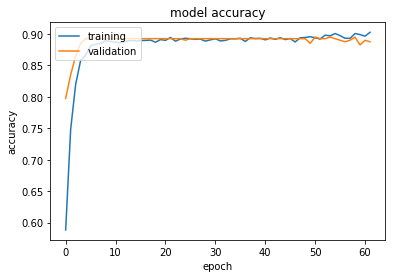

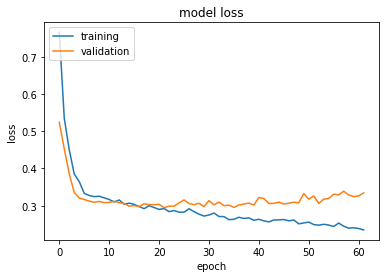

acc: 88.75%
loss: 0.33%
399/399 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step


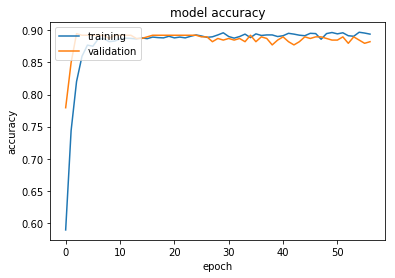

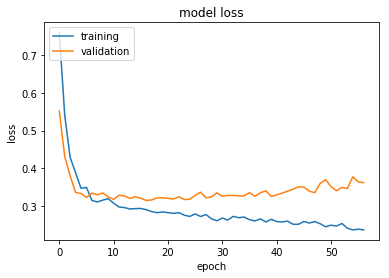

acc: 88.22%
loss: 0.36%
398/398 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step


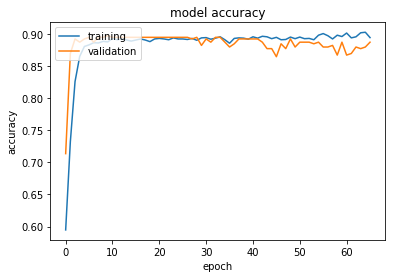

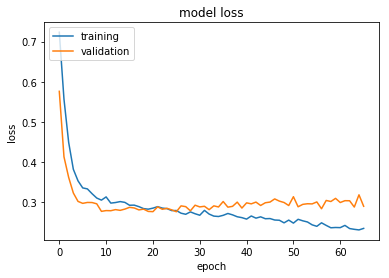

acc: 88.69%
loss: 0.29%
398/398 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step


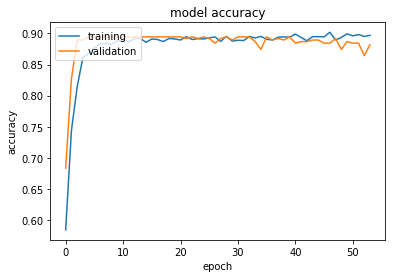

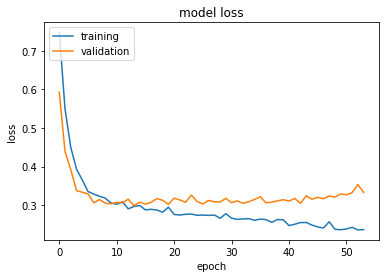

acc: 88.19%
loss: 0.33%
88.19% (+/- 0.82%)


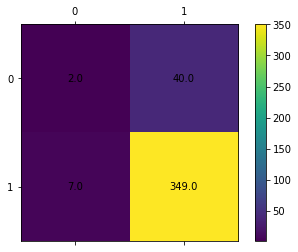

In [109]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    features = X_train.shape[1]
    model = init_model(features)
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Shapely + SVM
================

In [119]:
# X_train1 =new_summer_features[0:2200,:]
# X_test1 = new_summer_features[2200:2535,:]

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_summer_features, occ_summer_data.values, test_size=0.15, shuffle=True)

# X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
# X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)
X_test1.shape

(420, 20)

In [120]:
from sklearn.svm import SVC
svclassifier = SVC()
svclassifier.fit(X_train1, y_train1)

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [121]:
y_pred = svclassifier.predict(X_test1)

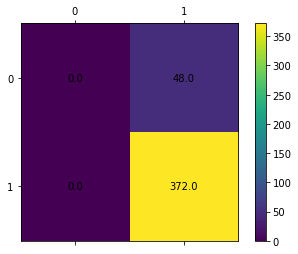

In [122]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


In [123]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test1, y_pred))

0.9071428571428571


K-fold
----------

In [124]:
from sklearn.model_selection import StratifiedKFold

In [125]:
Xs=new_summer_features
ys=occ_summer_data.values

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.25%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.25%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.25%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.25%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.22%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.45%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 89.45%
89.30% (+/- 0.09%)


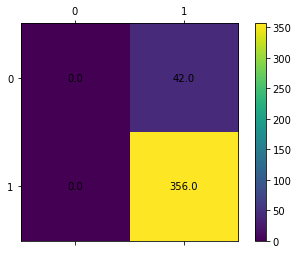

In [126]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train]
    X_test = Xs[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, ys[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    acc = accuracy_score(ys[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()